In [1]:
import wfdb
import neurokit2 as nk
import numpy as np
import pandas as pd
import os
from scipy.fftpack import fft
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight


2025-02-05 15:43:17.717080: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Dataset path
base_path = '/Users/chkv/Downloads/mit-bih-arrhythmia-database-1.0.0/'

# Define abnormal beat symbols
abnormal_symbols = {'L', 'R', 'A', 'V', 'F', '[', '!', ']', 'e', 'E', '/'}

# Segment length: 10 seconds at 360 Hz
segment_length = 360 * 10  


In [3]:
def process_record(record_name):
    record_path = base_path + record_name
    record = wfdb.rdrecord(record_path)
    annotation = wfdb.rdann(record_path, 'atr')
    
    # Extract ECG signal (first lead)
    ecg_signal = record.p_signal[:, 0]
    
    # Preprocess ECG signal
    ecg_cleaned = nk.ecg_clean(ecg_signal, sampling_rate=360)
    
    # Convert to frequency domain using FFT
    ecg_fft = np.abs(fft(ecg_cleaned))[:len(ecg_cleaned)//2]  

    # Determine if patient is abnormal
    abnormal_count = sum(1 for symbol in annotation.symbol if symbol in abnormal_symbols)
    total_beats = len(annotation.symbol)
    is_abnormal = 1 if (abnormal_count / total_beats) > 0.18 else 0
    
    return ecg_fft, is_abnormal


In [4]:
patient_segments = {}
patient_labels = {}

for file in os.listdir(base_path):
    if file.endswith('.dat'):
        record_name = file[:-4]
        patient_id = record_name[:3]  # Adjust based on patient ID format
        try:
            ecg_fft, label = process_record(record_name)
            num_segments = len(ecg_fft) // segment_length
            segments = [ecg_fft[i * segment_length : (i + 1) * segment_length] for i in range(num_segments)]
            patient_segments[patient_id] = segments
            patient_labels[patient_id] = label
        except Exception as e:
            print(f"Error processing {record_name}: {e}")


In [5]:
# Split patients into train and test
patient_ids = list(patient_labels.keys())
y_patients = [patient_labels[pid] for pid in patient_ids]
train_ids, test_ids = train_test_split(patient_ids, test_size=0.2, random_state=42, stratify=y_patients)

# Compile training and testing data
X_train, y_train, X_test, y_test = [], [], [], []

for pid in train_ids:
    X_train.extend(patient_segments[pid])
    y_train.extend([patient_labels[pid]] * len(patient_segments[pid]))

for pid in test_ids:
    X_test.extend(patient_segments[pid])
    y_test.extend([patient_labels[pid]] * len(patient_segments[pid]))

# Convert to numpy arrays and reshape for CNN
X_train = np.array(X_train).reshape(-1, segment_length, 1)
X_test = np.array(X_test).reshape(-1, segment_length, 1)
y_train = np.array(y_train)
y_test = np.array(y_test)


In [6]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: w for i, w in enumerate(class_weights)}


In [7]:
# Define CNN model
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(segment_length, 1)),
    MaxPooling1D(2),
    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile model
model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weights
)


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 60s 655ms/step - accuracy: 0.4946 - loss: 70.6940 - val_accuracy: 0.3684 - val_loss: 0.7083
Epoch 2/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 69s 801ms/step - accuracy: 0.5195 - loss: 0.6727 - val_accuracy: 0.6988 - val_loss: 0.7132
Epoch 3/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 49s 570ms/step - accuracy: 0.5682 - loss: 0.6262 - val_accuracy: 0.3904 - val_loss: 0.7996
Epoch 4/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 63s 730ms/step - accuracy: 0.5622 - loss: 0.6106 - val_accuracy: 0.3947 - val_loss: 0.8410
Epoch 5/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 55s 639ms/step - accuracy: 0.5724 - loss: 0.6139 - val_accuracy: 0.3918 - val_loss: 0.8368
Epoch 6/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 67s 462ms/step - accuracy: 0.5482 - loss: 0.6036 - val_accuracy: 0.4956 - val_loss: 1.2268
Epoch 7/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 42s 489ms/step - accuracy: 0.5778 - loss: 0.6349 - val_accuracy: 0.6009 - val_loss: 0.9277
Epoch 8/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 48s 560ms/step - accuracy: 0.5622 - loss: 0.6235 - val_acc

In [8]:
# Predict on test data
y_pred_prob = model.predict(X_test).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

# Compute Sensitivity (Recall) and Specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# Compute Precision-Recall AUC
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
pr_auc = auc(recall, precision)

# Compute ROC AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)


29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 236ms/step


In [9]:
# Create a summary DataFrame
summary = pd.DataFrame({
    'Metric': ['Accuracy', 'Sensitivity (Recall)', 'Specificity', 'ROC AUC', 'Precision-Recall AUC'],
    'Score': [
        (tp + tn) / (tp + tn + fp + fn),
        sensitivity,
        specificity,
        roc_auc,
        pr_auc
    ]
})

print("Model Evaluation Summary:")
display(summary)

# Print confusion matrix and classification report
print("Confusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Model Evaluation Summary:


,Metric,Score
0,Accuracy,0.614444
1,Sensitivity (Recall),0.408333
2,Specificity,0.751852
3,ROC AUC,0.587171
4,Precision-Recall AUC,0.476980


Confusion Matrix:
[[406 134]
 [213 147]]

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.75      0.70       540
           1       0.52      0.41      0.46       360

    accuracy                           0.61       900
   macro avg       0.59      0.58      0.58       900
weighted avg       0.60      0.61      0.60       900



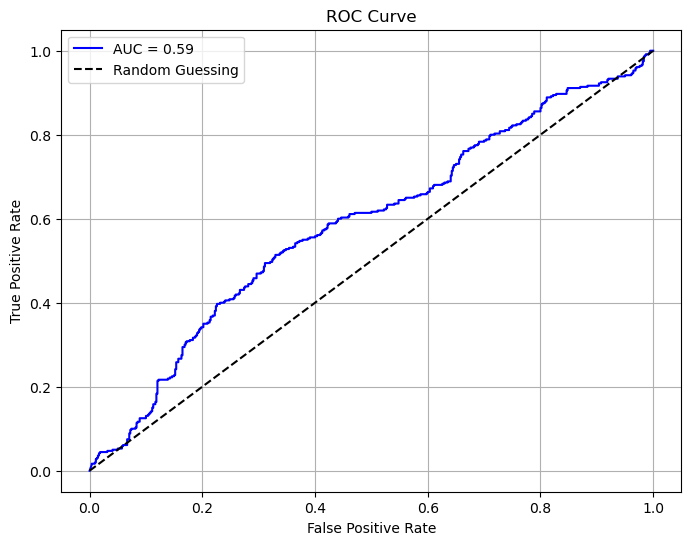

ROC AUC Score: 0.5872


In [10]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

print(f"ROC AUC Score: {roc_auc:.4f}")


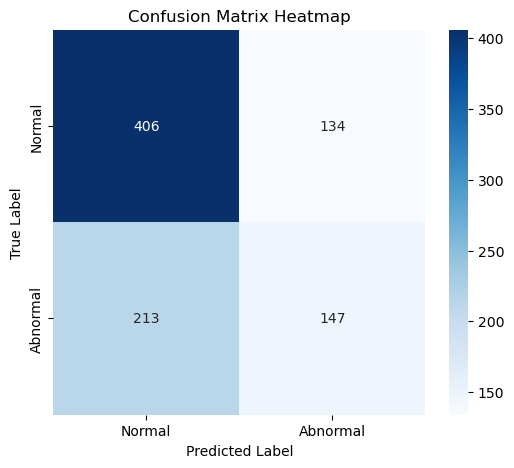

In [11]:
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Heatmap")
plt.show()



In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC Curve')
plt.legend()
plt.grid()
plt.show()

print(f"ROC AUC Score: {roc_auc:.4f}")